In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.15.0


In [8]:
# Create a list with the filepaths for training and testing
train_dir = Path('/content/drive/MyDrive/Food Dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [9]:
test_dir = Path('/content/drive/MyDrive/Food Dataset/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [10]:
val_dir = Path('/content/drive/MyDrive/Food Dataset/val')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [11]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [12]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [13]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 6000

Number of different labels: 12

Labels: ['chicken_curry' 'dumplings' 'samosa' 'donuts' 'ice_cream' 'fried_rice'
 'omelette' 'french_fries' 'spaghetti' 'apple_pie' 'pizza'
 'chocolate_cake']


In [24]:
train_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Food Dataset/train/chic...,chicken_curry
1,/content/drive/MyDrive/Food Dataset/train/dump...,dumplings
2,/content/drive/MyDrive/Food Dataset/train/dump...,dumplings
3,/content/drive/MyDrive/Food Dataset/train/samo...,samosa
4,/content/drive/MyDrive/Food Dataset/train/samo...,samosa


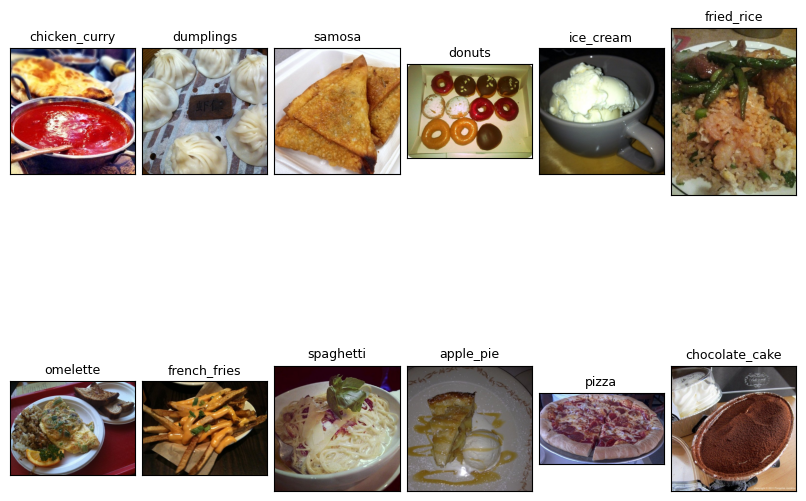

In [16]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 9)
plt.tight_layout(pad=0.5)
plt.show()

In [17]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [18]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 6000 validated image filenames belonging to 12 classes.


In [19]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2400 validated image filenames belonging to 12 classes.


In [20]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2400 validated image filenames belonging to 12 classes.


In [21]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 2s 0us/step


In [25]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
188/188 [==============================] - 6799s 36s/step - loss: 0.8853 - accuracy: 0.7207 - val_loss: 0.6252 - val_accuracy: 0.8033
Epoch 2/5
188/188 [==============================] - 35s 188ms/step - loss: 0.4791 - accuracy: 0.8448 - val_loss: 0.6133 - val_accuracy: 0.8108
Epoch 3/5
188/188 [==============================] - 39s 205ms/step - loss: 0.3391 - accuracy: 0.8897 - val_loss: 0.6423 - val_accuracy: 0.8138
Epoch 4/5
188/188 [==============================] - 37s 199ms/step - loss: 0.2508 - accuracy: 0.9187 - val_loss: 0.6015 - val_accuracy: 0.8283
Epoch 5/5
188/188 [==============================] - 35s 188ms/step - loss: 0.1519 - accuracy: 0.9555 - val_loss: 0.6603 - val_accuracy: 0.8171


In [29]:
import matplotlib.pyplot as plt

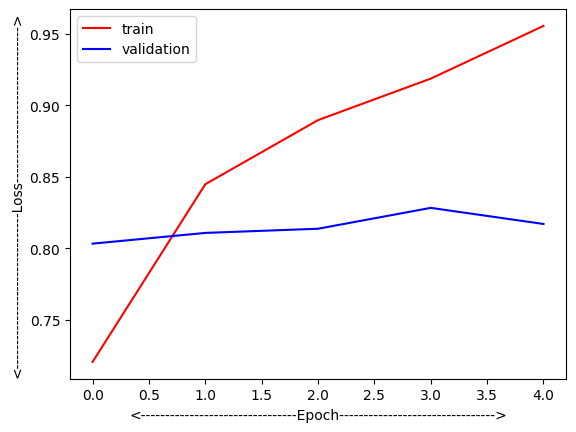

In [45]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.xlabel("<--------------------------------Epoch-------------------------------->")
plt.ylabel("<--------------------------------Loss-------------------------------->")
plt.show()

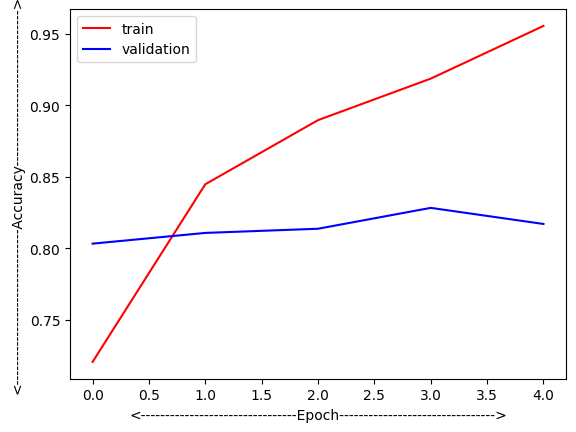

In [46]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.xlabel("<--------------------------------Epoch-------------------------------->")
plt.ylabel("<--------------------------------Accuracy-------------------------------->")
plt.show()

In [33]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

75/75 [==============================] - 12s 144ms/step


['chocolate_cake',
 'dumplings',
 'ice_cream',
 'chocolate_cake',
 'pizza',
 'omelette',
 'fried_rice',
 'donuts',
 'omelette',
 'dumplings',
 'samosa',
 'french_fries',
 'chicken_curry',
 'dumplings',
 'french_fries',
 'chicken_curry',
 'chocolate_cake',
 'chicken_curry',
 'french_fries',
 'french_fries',
 'chicken_curry',
 'chocolate_cake',
 'fried_rice',
 'donuts',
 'chocolate_cake',
 'fried_rice',
 'samosa',
 'french_fries',
 'french_fries',
 'donuts',
 'dumplings',
 'donuts',
 'dumplings',
 'fried_rice',
 'fried_rice',
 'omelette',
 'dumplings',
 'french_fries',
 'omelette',
 'samosa',
 'dumplings',
 'fried_rice',
 'omelette',
 'donuts',
 'spaghetti',
 'pizza',
 'chocolate_cake',
 'samosa',
 'fried_rice',
 'french_fries',
 'omelette',
 'chicken_curry',
 'samosa',
 'samosa',
 'omelette',
 'chicken_curry',
 'chocolate_cake',
 'apple_pie',
 'omelette',
 'samosa',
 'dumplings',
 'omelette',
 'samosa',
 'dumplings',
 'samosa',
 'chocolate_cake',
 'chocolate_cake',
 'apple_pie',
 'dumpl

In [34]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

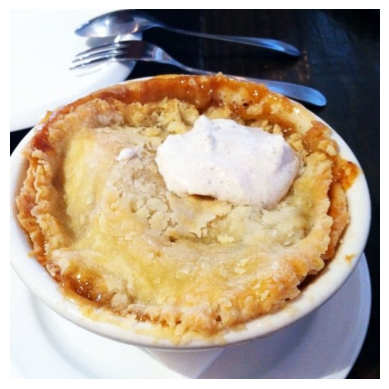

In [42]:
img1=mpimg.imread('/content/drive/MyDrive/Food Dataset/test/apple_pie/1113017.jpg')
plt.imshow(img1)
plt.axis('off')
plt.show()

In [43]:
img = output('/content/drive/MyDrive/Food Dataset/test/apple_pie/1113017.jpg')
img

1/1 [==============================] - 0s 33ms/step


'apple_pie'

In [44]:
model.save('MODEL.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
